<a href="https://colab.research.google.com/github/jakob-ra/Adv-Ectrics-III/blob/master/AE3_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from functools import partial
import seaborn as sns

# Advanced Econometrics III
## Assignment 2

## 1.1
We simulate time series from a Local Level Model with initial conditions $\mu_1 \sim \mathcal{N}(0,100)$ and variances $\sigma_\epsilon^2=1$ and $\sigma_\eta^2=q$ with $q \in \{10,1,0.1,0.001\}$.

In [0]:
def sim(N, var_eps, var_eta, mu1_mean, mu1_var):
    """
    Purpose:
      Simulate time series from a Local Level Model
    Inputs:
      N           int, number of observations to be created
      var_eps     float, variance of epsilon
      var_eta     float, variance of eta
      mu1_mean    float, mean of initial obs
      mu1_var     float, variance of initial obs
    Returns:
      vY           array, observation vector
      vMu          array, vector of means
      vEps         array, vector of epsilons
      vEta         array, vector of etas
    """
    mu1 = np.random.normal(loc=mu1_mean, scale=np.sqrt(mu1_var))
    vEps = np.random.normal(scale=np.sqrt(var_eps),size=N)
    vEta = np.random.normal(scale=np.sqrt(var_eta),size=N)
    
    vMu = [mu1]
    for i in range(N-1):
      vMu.append(vMu[-1]+vEta[i])
    
    vY = []
    for i in range(N):
      vY.append(vMu[i]+vEps[i])
      
    return vY, vMu, vEps, vEta

Now we plot the simulated series and its time-varying mean.

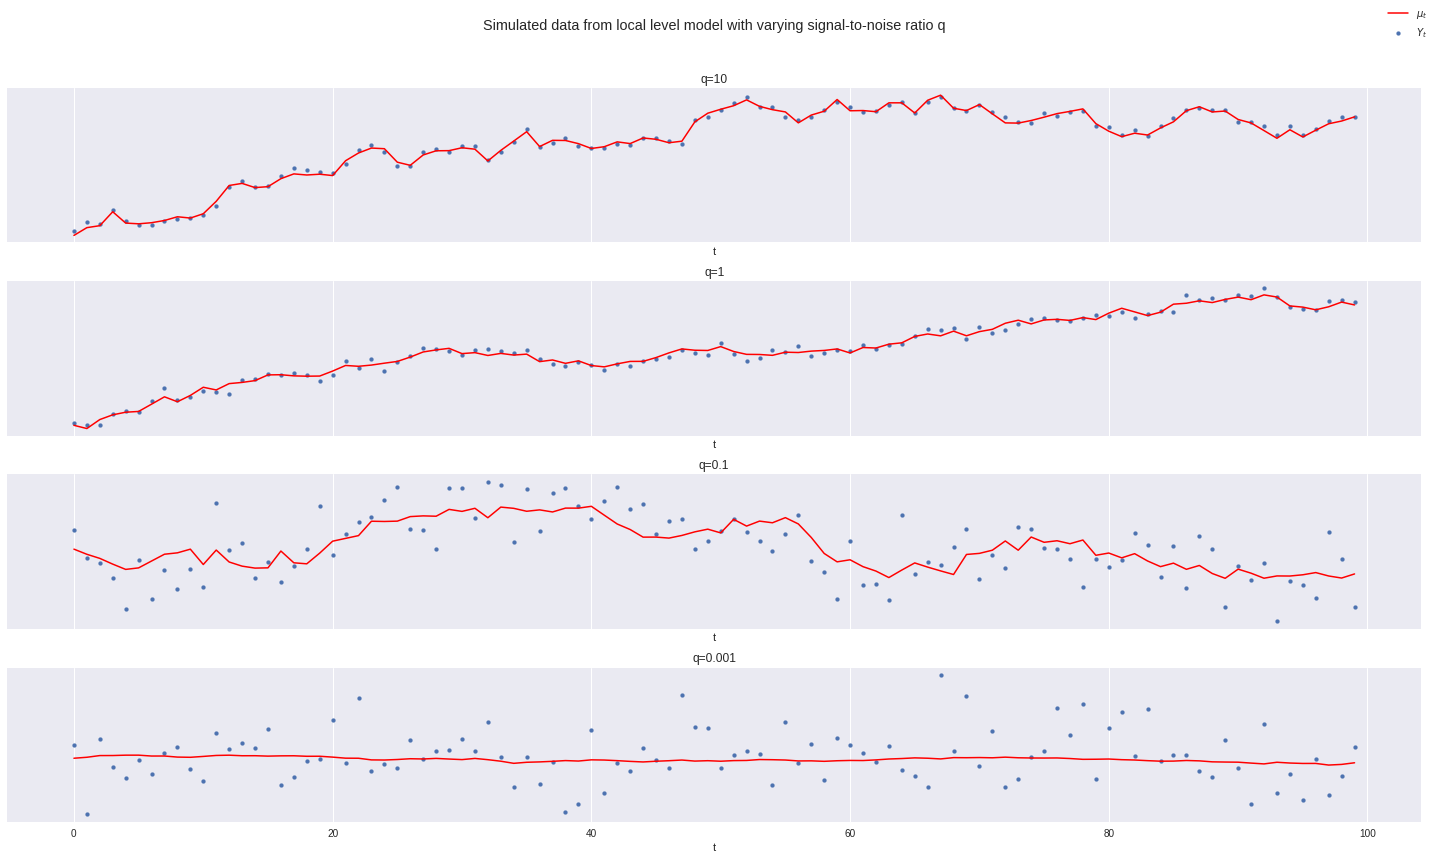

In [123]:
# Inputs
N = 100
var_eps = 1
mu1_mean = 0
mu1_var = 100
q_values = [10,1,0.1,0.001]


# Plot observations and level for each value in q_values
fig, axs = plt.subplots(len(q_values),1, figsize=(20,12), sharex=True)

i = 0
for q in q_values:
  var_eta = q
  vY, vMu = sim(N, var_eps, var_eta, mu1_mean, mu1_var)[:2]
  
  axs[i].scatter(np.arange(N),vY, label=r'$Y_t$', s=15)
  axs[i].plot(np.arange(N),vMu, label=r'$\mu_t$',  lw=1.5, color='r')
  
  title = 'q='+str(q)
  axs[i].set_title(title)
  axs[i].set_xlabel('t')
  axs[i].set_yticks([], [])
  i += 1
  
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle('Simulated data from local level model with varying signal-to-noise ratio q')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

As the signal-to-noise ratio decreases,  the underlying trend is harder and harder to make out.

## 2.1
Next, we implement the Kalman filter and apply it to the four series created in 1.1.

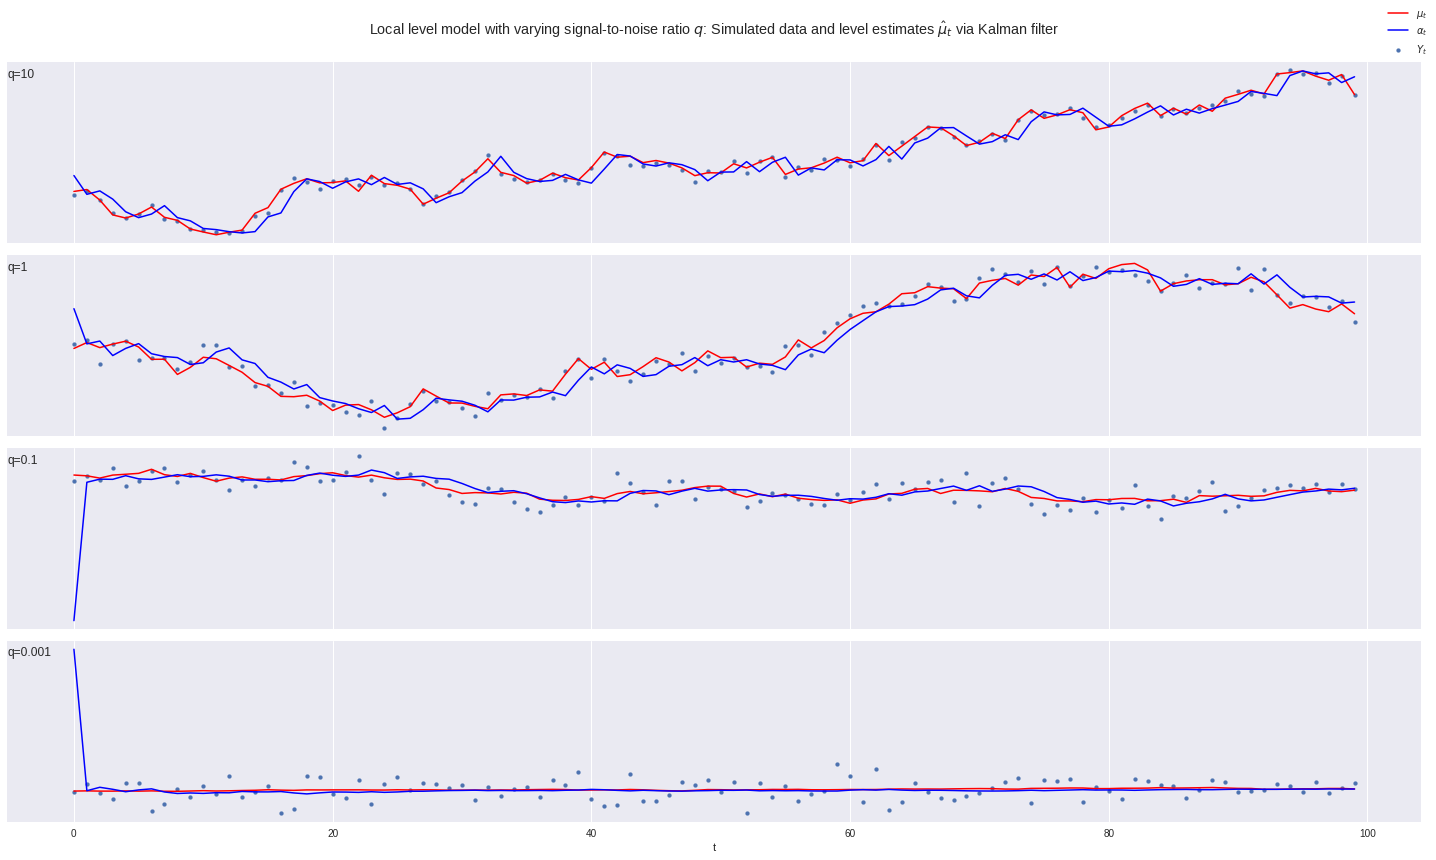

In [124]:
def kalman_filter(vY, var_eps, var_eta, a1, P1):
    """
    Purpose:
      Applies the Kalman filter corresponding to a local level model to a given time series vY
    Inputs:
      vY          array, time series
      var_eps     float, variance of epsilon
      var_eta     float, variance of eta
      a1          array, initial state mean vector
      P1          array, initial state variance vector
    Returns:
      vA          array, estimated state (mean) vector
      vP          array, estimated state variance vector
      vK          array, estimated k's for observation weights
      vV          array, vector of prediction errors
      vF          array, vector of prediction variances
      vA_hat      array, smoothed state vector
      vP_hat      array, vector of smoothed variances
      vR          array, vector of smoothing cumulant
      vN          array, vector of smoothing variance cumulant
      vEps_hat    array, vector of smoothed disturbances
      vEta_hat    array, vector of smoothed state disturbances
      vEps_hat_var    array, vector of smoothed disturbance variances
      vEta_hat_var    array, vector of smoothed state disturbance variances
    """
    
    N = len(vY)
    
    # Filter
    vK = []
    vV = []
    vF = []
    vA = [a1]
    vP = [P1]
    for t in range(N):
      # Exception for missing observations
      if np.isnan(vY[t]):
        v = 0
        f = 10**10
        k = 0
        vV.append(v)
        vF.append(f)
        vK.append(k)
        vA.append(vA[-1])
        vP.append(vP[-1] + var_eta)
        continue
      # Non-missing
      v = vY[t] - vA[-1]
      f = vP[-1] + var_eps
      k = vP[-1] / f
      vV.append(v)
      vF.append(f)
      vK.append(k)
      vA.append(vA[-1] + k*v)
      vP.append(k*var_eps + var_eta)
    
    # Smoothing
    vR = np.zeros(N+1)
    vN = np.zeros(N+1)
    for t in np.arange(N,1,-1):
      vR[t-1] = vV[t-1]/vF[t-1] + (1-vK[t-1])*vR[t]
      vN[t-1] = 1/vF[t-1] + (1-vK[t-1])**2*vN[t]
    vA_hat = [vA[t] + vP[t]*vR[t] for t in range(N)]  
    vP_hat = [vP[t] - vP[t]**2*vN[t] for t in range(N)]
    
    # Smoothed disturbances
    vEps_hat = np.array(vY) - np.array(vA_hat)
    vEps_hat_var = [var_eps*(1-var_eps*(1/vF[t]+vK[t]**2*vN[t])) for t in range(N)]
    vEta_hat = [vA_hat[t+1]-vA_hat[t] for t in range(N-1)]
    vEta_hat_var = [var_eta*(1-var_eta*vN[t]) for t in range(N)]
    
    return vA, vP, vK, vV, vF, vA_hat, vP_hat, vR, vN, vEps_hat, vEta_hat, vEps_hat_var, vEta_hat_var

# Set initial values to 'true' initial values
a1 = mu1_mean
P1 = mu1_var

# Plot observations, level, and Kalman filter estimates of level for each value in q_values
fig, axs = plt.subplots(len(q_values),1, figsize=(20,12), sharex=True)

i = 0
for q in q_values:
  var_eta = q
  vY, vMu = sim(N, var_eps, var_eta, mu1_mean, mu1_var)[:2]
  vA = kalman_filter(vY, var_eps, var_eta, a1, P1)[0]
  
  axs[i].scatter(np.arange(N),vY, label=r'$Y_t$', s=15)
  axs[i].plot(np.arange(N),vMu, label=r'$\mu_t$',  lw=1.5, color='r')
  axs[i].plot(np.arange(N),vA[:-1], label=r'$\alpha_t$',  lw=1.5, color='b')
  
  title = 'q='+str(q)
  axs[i].set_title(title, loc='left', pad=-15)
  axs[i].set_yticks([], [])
  i += 1
  
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
axs[-1].set_xlabel('t')
fig.suptitle(r'Local level model with varying signal-to-noise ratio $q$: Simulated data and level estimates $\hat{\mu}_t$ via Kalman filter')
plt.tight_layout()
plt.subplots_adjust(top=0.93)

Text(0.5, 0.98, 'Average observation weights of Kalman filter for first 20 lags; for different signal-to-noise ratios q')

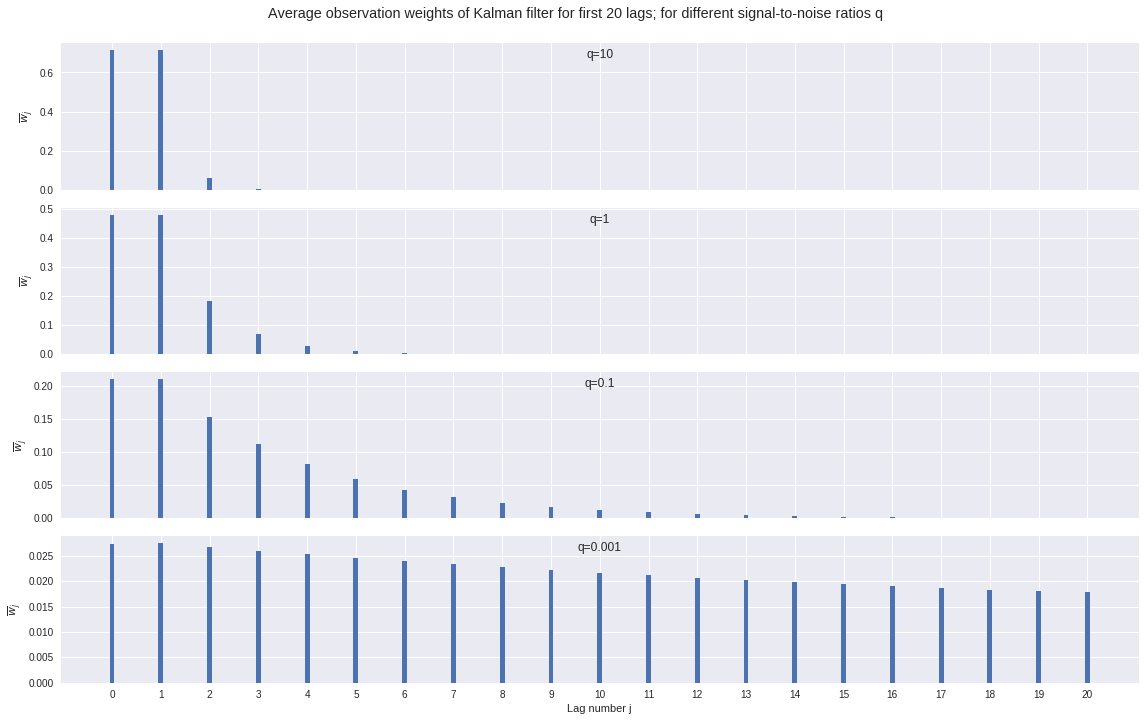

In [125]:
# Plot average observation weights of Kalman filter for first 20 lags; for each value in q_values
max_l = 21

fig, axs = plt.subplots(len(q_values),1, figsize=(16,10), sharex=True)

i = 0
for q in q_values:
  var_eta = q
  vY, vMu = sim(N, var_eps, var_eta, mu1_mean, mu1_var)[:2]
  
  vK = kalman_filter(vY, var_eps, var_eta, a1, P1)[2]
  mW = np.zeros((N,max_l))
  for t in range(max_l,N-1):
    for j in range(max_l):
      mW[t,j] = vK[t-j]*np.prod([1-vK[t-m] for m in range(j-1)])
    
  axs[i].bar(np.arange(max_l),np.mean(mW,axis=0), width=0.1)
  axs[i].set_ylabel(r'$\overline{w}_j$')
  title = 'q='+str(q)
  axs[i].set_title(title, loc='center', pad=-15)
  i += 1
  

plt.tight_layout()
plt.subplots_adjust(top=0.93)
axs[-1].set_xticks(np.arange(max_l))
axs[-1].set_xlabel('Lag number j')
fig.suptitle('Average observation weights of Kalman filter for first 20 lags; for different signal-to-noise ratios q')

As we can see, for lower signal-to-noise ratios, the Kalman filter weights distant observations more heavily. This is because the  disturbances at each period have large variance, so in order to extract the signal we have to use a weighted average of a larger number of lags. Consider for instance, the extreme case of $q=0$. This is a global level model, and we find the location of this global level by taking the average over all observations. On the other extreme, as $q$ approaches infinity, the series becomes a random walk, for which our 'best prediction' of the next value is just the last value (so all the weight lies on the last observation).

## 2.2
First we import the Nile data.

In [126]:
# Download the data from Github. Note that the file is first deleted if it
# already exists in the directory.
!rm -f Nile.dat
!wget https://raw.githubusercontent.com/jakob-ra/Adv-Ectrics-III/master/Nile.dat

# List the files in the current folder to show the download was successful.
!ls

--2019-04-09 16:55:14--  https://raw.githubusercontent.com/jakob-ra/Adv-Ectrics-III/master/Nile.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600 [text/plain]
Saving to: ‘Nile.dat’

Nile.dat            100%[===================>]     600  --.-KB/s    in 0s      

2019-04-09 16:55:14 (75.4 MB/s) - ‘Nile.dat’ saved [600/600]

Nile.dat  sample_data


Text(0.5, 0.98, 'Fig. 2.1')

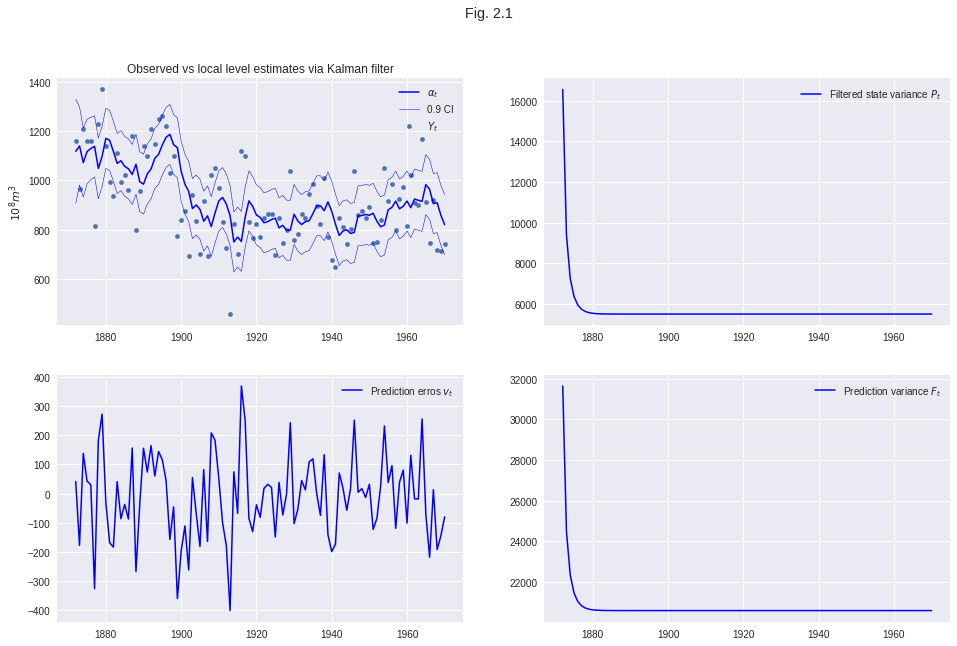

In [127]:
# Load data into vector
vY = np.loadtxt( 'Nile.dat' )

# Create loval level estimates via Kalman filter
a1 = 0
P1 = 10**7
var_eps =  15099
var_eta =  1469.1
vA, vP, vK, vV, vF, vA_hat, vP_hat, vR, vN, vEps_hat, vEta_hat, vEps_hat_var, vEta_hat_var = np.array(kalman_filter(vY, var_eps, var_eta, a1, P1))

# Create confidence interval
conf_level = 0.9
z = scipy.stats.norm.ppf(1-(1-conf_level)/2)
vA_upper = vA + z*np.sqrt(vP)
vA_lower = vA - z*np.sqrt(vP)


# Figure 1
x_vals = np.arange(1872,1971)

fig, axs = plt.subplots(2,2, figsize=(16,10))

axs[0,0].scatter(x_vals, vY[1:], s=20, label=r'$Y_t$')
axs[0,0].plot(x_vals, vA[1:-1], label=r'$\alpha_t$',  lw=1.5, color='b')
axs[0,0].plot(x_vals, vA_upper[1:-1], lw=0.5, color='b', label='0.9 CI')
axs[0,0].plot(x_vals, vA_lower[1:-1], lw=0.5, color='b')
axs[0,0].set_title('Observed vs local level estimates via Kalman filter')
axs[0,0].set_ylabel(r'$10^8 m^3$')
axs[0,0].legend()

axs[0,1].plot(x_vals, vP[1:-1], label=r'Filtered state variance $P_t$',  lw=1.5, color='b')
axs[0,1].legend()

axs[1,0].plot(x_vals, vV[1:], label=r'Prediction erros $v_t$',  lw=1.5, color='b')
axs[1,0].legend()

axs[1,1].plot(x_vals, vF[1:], label=r'Prediction variance $F_t$',  lw=1.5, color='b')
axs[1,1].legend()

fig.suptitle('Fig. 2.1')

Text(0.5, 0.98, 'Fig. 2.2')

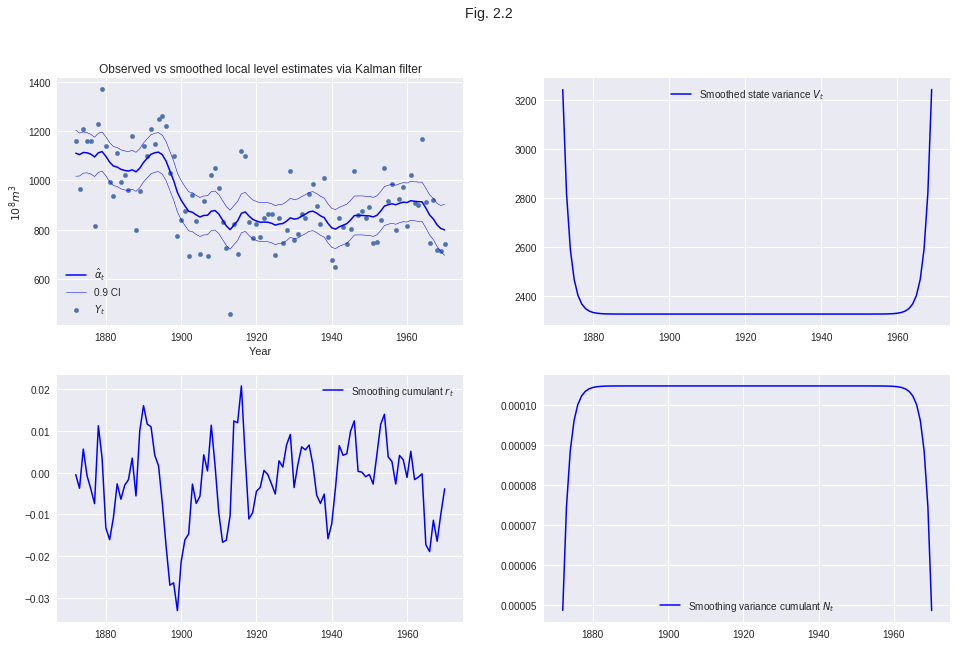

In [128]:
# Create smoothed confidence interval
vA_hat_upper = vA_hat + z*np.sqrt(vP_hat)
vA_hat_lower = vA_hat - z*np.sqrt(vP_hat)


# Figure 2
fig, axs = plt.subplots(2,2, figsize=(16,10))

axs[0,0].scatter(x_vals, vY[1:], s=20, label=r'$Y_t$')
axs[0,0].plot(x_vals, vA_hat[1:], label=r'$\hat{\alpha}_t$',  lw=1.5, color='b')
axs[0,0].plot(x_vals, vA_hat_upper[1:], lw=0.5, color='b', label='0.9 CI')
axs[0,0].plot(x_vals, vA_hat_lower[1:], lw=0.5, color='b')
axs[0,0].set_title('Observed vs smoothed local level estimates via Kalman filter')
axs[0,0].set_xlabel('Year')
axs[0,0].set_ylabel(r'$10^8 m^3$')
axs[0,0].legend()

axs[0,1].plot(x_vals[:-1], vP_hat[1:-1], label=r'Smoothed state variance $V_t$',  lw=1.5, color='b')
axs[0,1].legend()

axs[1,0].plot(x_vals, vR[1:-1], label=r'Smoothing cumulant $r_t$',  lw=1.5, color='b')
axs[1,0].legend()

axs[1,1].plot(x_vals, vN[1:-1], label=r'Smoothing variance cumulant $N_t$',  lw=1.5, color='b')
axs[1,1].legend()

fig.suptitle('Fig. 2.2')

Text(0.5, 0.98, 'Fig. 2.3')

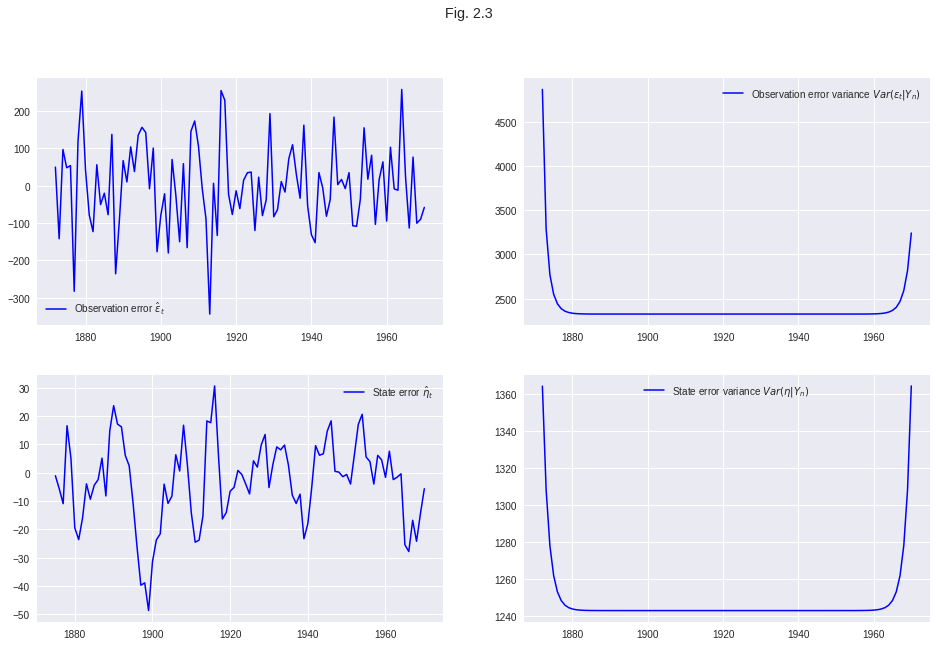

In [129]:
# Figure 3
fig, axs = plt.subplots(2,2, figsize=(16,10))

axs[0,0].plot(x_vals, vEps_hat[1:], label=r'Observation error $\hat{\epsilon}_t$',  lw=1.5, color='b')
axs[0,0].legend()

axs[0,1].plot(x_vals, vEps_hat_var[1:], label=r'Observation error variance $Var(\epsilon_t|Y_n)$',  lw=1.5, color='b')
axs[0,1].legend()

axs[1,0].plot(x_vals[3:], vEta_hat[3:], label=r'State error $\hat{\eta}_t$',  lw=1.5, color='b')
axs[1,0].legend()

axs[1,1].plot(x_vals, vEta_hat_var[1:], label=r'State error variance $Var(\eta|Y_n)$',  lw=1.5, color='b')
axs[1,1].legend()

fig.suptitle('Fig. 2.3')

Text(0.5, 0.98, 'Fig. 2.4')

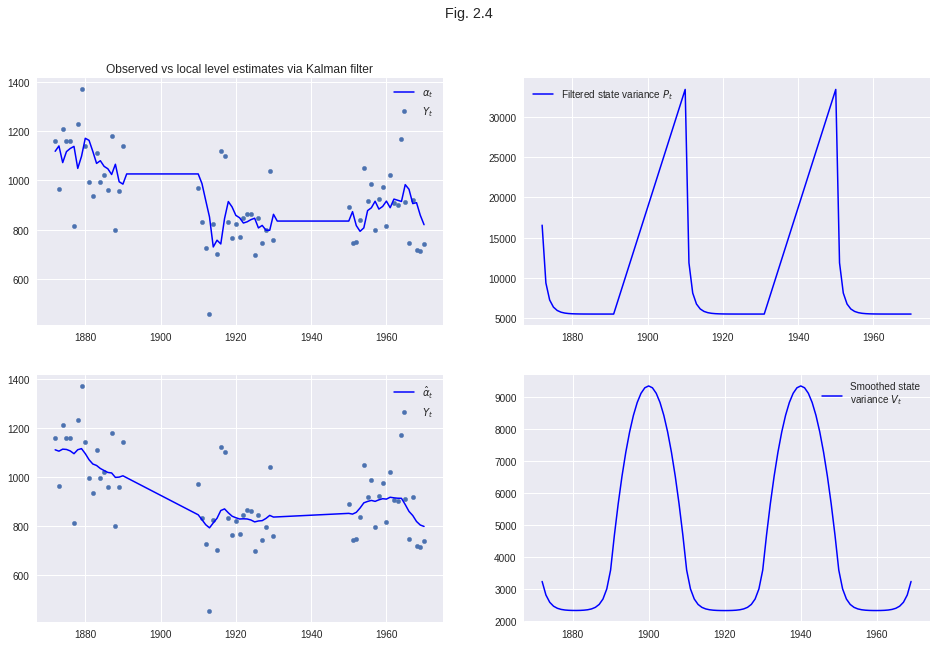

In [130]:
# Set two periods of data to missing
vY_mis = np.copy(vY)
for t in range(20,39):
  vY_mis[t] = np.nan
for t in range(60,79):
  vY_mis[t] = np.nan

# Rerun Kalman filter
vA, vP, vK, vV, vF, vA_hat, vP_hat, vR, vN, vEps_hat, vEta_hat, vEps_hat_var, vEta_hat_var = np.array(kalman_filter(vY_mis, var_eps, var_eta, a1, P1))

# Figure 4
fig, axs = plt.subplots(2,2, figsize=(16,10))

axs[0,0].scatter(x_vals, vY_mis[1:], s=20, label=r'$Y_t$')
axs[0,0].plot(x_vals, vA[1:-1], label=r'$\alpha_t$',  lw=1.5, color='b')
axs[0,0].set_title('Observed vs local level estimates via Kalman filter')
axs[0,0].legend()

axs[0,1].plot(x_vals, vP[1:-1], label=r'Filtered state variance $P_t$',  lw=1.5, color='b')
axs[0,1].legend()

axs[1,0].scatter(x_vals, vY_mis[1:], s=20, label=r'$Y_t$')
axs[1,0].plot(x_vals, vA_hat[1:], label=r'$\hat{\alpha}_t$', lw=1.5, color='b')
axs[1,0].legend()

axs[1,1].plot(x_vals[:-1], vP_hat[1:-1], label=r'Smoothed state' + '\n' + 'variance $V_t$',  lw=1.5, color='b')
axs[1,1].legend()

fig.suptitle('Fig. 2.4')

Text(0.5, 0.98, 'Fig. 2.5')

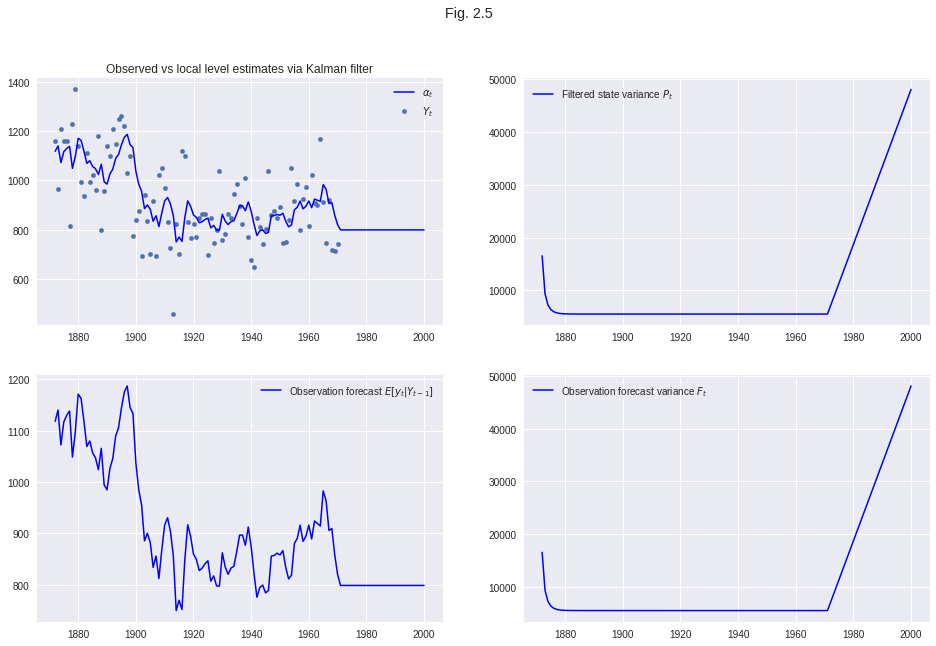

In [145]:
# Forecast for j periods ahead
j = 30
vY_f = np.append(vY, [np.nan]*j)

# Rerun Kalman filter
vA, vP, vK, vV, vF, vA_hat, vP_hat, vR, vN, vEps_hat, vEta_hat, vEps_hat_var, vEta_hat_var = np.array(kalman_filter(vY_f, var_eps, var_eta, a1, P1))

# Figure 5
x_vals_f = np.arange(1872,1971+j)

fig, axs = plt.subplots(2,2, figsize=(16,10))

axs[0,0].scatter(x_vals_f, np.append(vY[1:], [np.nan]*j), s=20, label=r'$Y_t$')
axs[0,0].plot(x_vals_f, vA[1:-1], label=r'$\alpha_t$',  lw=1.5, color='b')
axs[0,0].set_title('Observed vs local level estimates via Kalman filter')
axs[0,0].legend()

axs[0,1].plot(x_vals_f, vP[1:-1], label=r'Filtered state variance $P_t$',  lw=1.5, color='b')
axs[0,1].legend()

axs[1,0].plot(x_vals_f, vA[1:-1], label=r'Observation forecast $E[y_t|Y_{t-1}]$', lw=1.5, color='b')
axs[1,0].legend()

axs[1,1].plot(x_vals_f, vP[1:-1], label=r'Observation forecast variance $F_t$',  lw=1.5, color='b')
axs[1,1].legend()

fig.suptitle('Fig. 2.5')


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
No handles with labels found to put in legend.


Our estimates are 15094.020816402255 and 1479.5059056596247


Text(0.5, 0.98, 'Fig. 2.7')

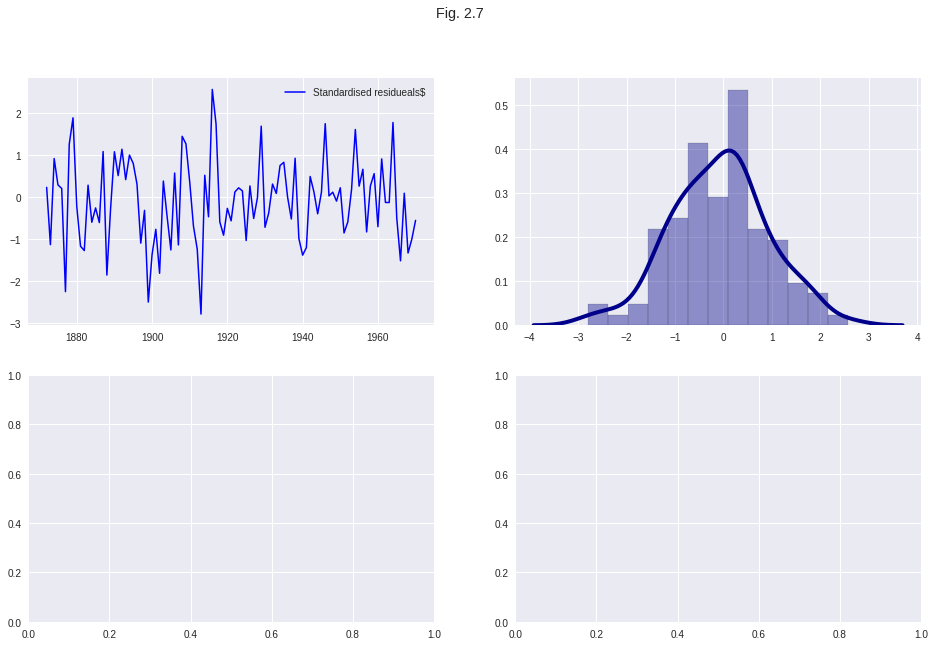

In [192]:
def log_lik_kalman(vY, a1, P1, params):
  """
  Purpose:
    Returns negative log-likelihood given data and parameters 
  Inputs:
    vY          array, time series
    a1          array, initial state mean vector
    P1          array, initial state variance vector
    params      array, contains var_eps and var_eta, the parameters to be optimized over
  Returns:
    loglik      float, log-likelihood value
  """
  var_eps, var_eta = params
    
  # Run Kalman filter
  vA, vP, vK, vV, vF = np.array(kalman_filter(vY, var_eps, var_eta, a1, P1))[:5]

  # Calculate log-likelihood
  N = len(vY)
  loglik = N/2*np.log(2*np.pi)+1/2*sum([np.log(vF[t])+vV[t]**2/vF[t] for t in range(N)])

  return loglik

#print(log_lik_kalman(vY, a1, P1, [1,1]))
optfunc = partial(log_lik_kalman, vY, a1, P1)
est = scipy.optimize.minimize(optfunc, [15000,1000], method='BFGS')
var_eps_h, var_eta_h = est.x
print(r'Our estimates are', var_eps_h, 'and', var_eta_h)

# Rerun Kalman filter with estimates
vA, vP, vK, vV, vF = np.array(kalman_filter(vY, var_eps_h, var_eta_h, a1, P1))[:5]
vE = [vV[t]/np.sqrt(vF[t]) for t in range(N)]

# Figure 6
x_vals_f = np.arange(1872,1971+j)

fig, axs = plt.subplots(2,2, figsize=(16,10))

axs[0,0].plot(x_vals, vE[1:], label='Standardised residueals$',  lw=1.5, color='b')
axs[0,0].legend()

sns.distplot(vE, hist=True, kde=True, 
             bins=13, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axs[0,1])
axs[0,1].legend()

# axs[1,0].plot(x_vals_f, vA[1:-1], label=r'Observation forecast $E[y_t|Y_{t-1}]$', lw=1.5, color='b')
# axs[1,0].legend()

# axs[1,1].plot(x_vals_f, vP[1:-1], label=r'Observation forecast variance $F_t$',  lw=1.5, color='b')
# axs[1,1].legend()

fig.suptitle('Fig. 2.7')

In [156]:
def conc_dif_lik_kalman(vY, var_eps_h, a1, P1, phi):
    """
    Purpose:
      Concentrated diffuse log-likelihood given data and parameters 
    Inputs:
      vY          array, time series
      var_eps_h   float, estimated variance of epsilon
      a1          array, initial state mean vector
      P1          array, initial state variance vector
      phi         float, log of the signal-to-noise ratio, parameter to be optimized over
    Returns:
      loglik      float, log-likelihood value
    """
    q = np.exp(phi)
    var_eta = q*var_eps_h
    
    # Run Kalman filter
    vA, vP, vK, vV, vF = np.array(kalman_filter(vY, var_eps_h, var_eta, a1, P1))[:5]
    
    # Calculate log-likelihood
    N = len(vY)
    loglik = -N/2*np.log(2*np.pi)-(N-1)/2*(1+np.log(var_eps_h))-1/2*sum([np.log(vF[t]) for t in range(1,N)])
    
    return loglik
  
# Optimize
def max_lik_kalman(vY, a1, P1, phi0=0):
  """
  Purpose:
    Maximum likelihood estimation of parameters in local level model given data 
  Inputs:
    vY          array, time series
    a1          array, initial state mean vector
    P1          array, initial state variance vector
    phi0        float, initial guess for phi
  Returns:
    var_eps_h   float, estimated variance of epsilon
    var_eta_h   float, estimated variance of eta
  """
  N = len(vY)
  vV, vF = np.array(kalman_filter(vY, var_eps_h, var_eta, a1, P1))[3:5]
  var_eps_h = 1/(N-1)*sum([vV[t]**2/vF[t] for t in range(1,N)])

  optfunc = partial(conc_dif_lik_kalman, vY, var_eps_h, a1, P1)
  var_eta_h = scipy.optimize.minimize(optfunc, phi0, method='BFGS')

  return var_eps_h, var_eta_h

print(max_lik_kalman(vY, a1, P1))

UnboundLocalError: ignored